In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, dual_annealing, basinhopping
import os 
import skfda 

In [2]:
if not os.path.exists('figures_noisy'):
    os.mkdir('figures_noisy')

In [3]:
SEIR_outputs =   pd.read_csv('noisy_seir_results.csv')
true_incidence =  SEIR_outputs['scaled_incidence'].to_numpy()
symptomatic_incidence =  SEIR_outputs['symptomatic_incidence'].to_numpy()


In [4]:
def wiener_deconvolution(signal, kernel, lambd):
	"lambd is the SNR"
	kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
	H = fft(kernel)
	deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + lambd**2)))
	return deconvolved

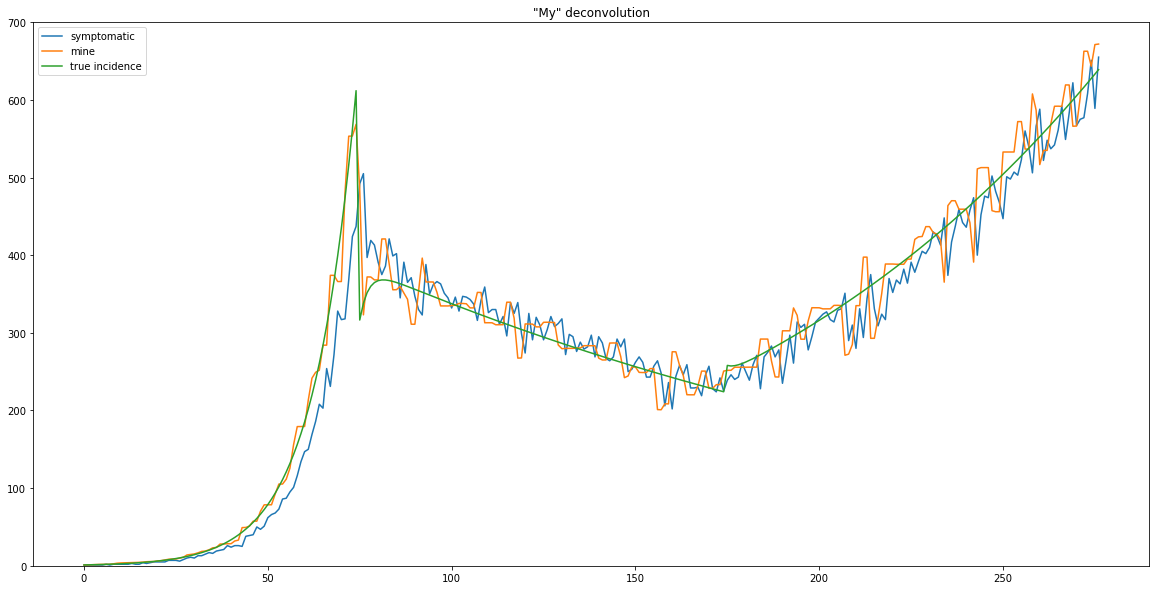

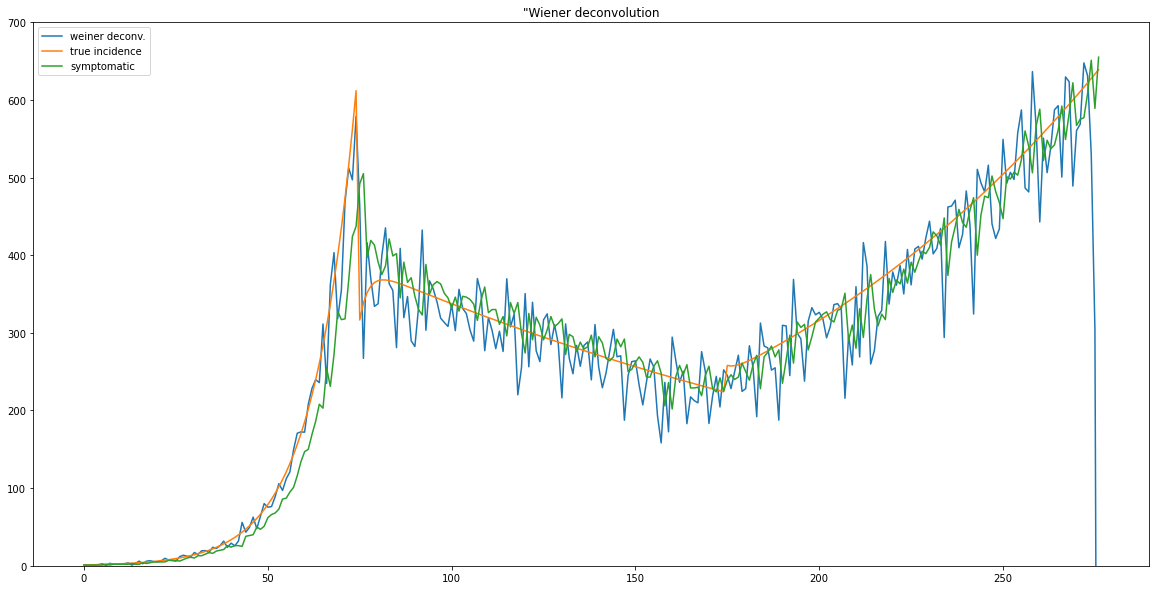

In [32]:
true_kernel = pd.read_csv('serial_interval.csv')['si']#'incubation_interval.csv')['pdf']


def optimizer_function(real_incidence):
    convolved = np.convolve(real_incidence, true_kernel, mode='valid')
    scaled_convolved = convolved/np.max(symptomatic_incidence[len(true_kernel)-1:]) *1000000
    scaled_incidence = symptomatic_incidence[len(true_kernel)-1:]/np.max(symptomatic_incidence[len(true_kernel)-1:]) *1000000

    penalty = 1E10 * np.mean(np.abs(np.diff(real_incidence)/np.max(symptomatic_incidence[len(true_kernel)-1:])))


    return np.mean((scaled_convolved - scaled_incidence)**2)+ penalty
weiner_deconvolved = wiener_deconvolution(symptomatic_incidence, true_kernel, 0.2)


x0 = symptomatic_incidence 
xs = minimize(optimizer_function, x0, bounds = [(0, np.inf) for _ in x0],options={'maxiter':200000})


plt.figure(figsize=(20, 10))
L = (len(true_kernel)-1)
plt.plot(symptomatic_incidence[L:], label='symptomatic')

plt.plot(xs.x[L:], label='mine')
plt.plot(true_incidence[L:], label='true incidence')

plt.title('"My" deconvolution')

plt.legend()
plt.ylim(0, 700)
plt.savefig('figures_noisy/my_deconv.png')
plt.show()

# The problem with Wiener deconvolution is that higher penalty not only smooths, but lowers it...
plt.figure(figsize=(20, 10))
plt.plot(weiner_deconvolved[L:], label='weiner deconv.')
plt.plot(true_incidence[L:], label='true incidence')
plt.title('Wiener deconvolution')
plt.plot(symptomatic_incidence[L:], label='symptomatic')

plt.legend()
plt.ylim(0, 700)
plt.savefig('figures_noisy/wiener_deconv.png')

plt.show()
